### Improvements 
1) Remove blinks and interpolate values using cubic splines
2) Blank filtering of data---Done-- maibe explore other filter
3) Frequency analysis of the signal??
4) Remove trials with z scores over [2,-2]
5) Convert time to seconds
6) Open PLA file
7) Statistics of signal ¿How to compare surprise signals?
8) Amplitud, velocidad de cambio


In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import commons as cm
from data_curation import Normalization
nm=Normalization()


recording_location = r"C:\Users\Bolo\Desktop\Laboratorio\incipit\data\pupil_emotibit\ES0001_S002_PC_EM\data\pupil_labs\002"
image_location=r"../../../../data/pupil_emotibit/ES0001_S002_PC_EM/images_order"

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
print_file_structure(recording_location)


exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)
exported_gaze_csv = os.path.join(recording_location, 'exports', '000', 'gaze_positions.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location, 'exports', '000', 'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)

002/
    annotation.pldata
    annotation_timestamps.npy
    blinks.pldata
    blinks_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    fixations.pldata
    fixations_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        000/
            annotations.csv
            blink_detection_report.csv
            blinks.csv
            export_info.csv
            fixation_report.csv
            fixations.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            world.mp4
            world_timestamps.csv
            world_timestamps.npy
  

In [2]:
pupil_pd_frame.columns

Index(['pupil_timestamp', 'world_index', 'eye_id', 'confidence', 'norm_pos_x',
       'norm_pos_y', 'diameter', 'method', 'ellipse_center_x',
       'ellipse_center_y', 'ellipse_axis_a', 'ellipse_axis_b', 'ellipse_angle',
       'diameter_3d', 'model_confidence', 'model_id', 'sphere_center_x',
       'sphere_center_y', 'sphere_center_z', 'sphere_radius',
       'circle_3d_center_x', 'circle_3d_center_y', 'circle_3d_center_z',
       'circle_3d_normal_x', 'circle_3d_normal_y', 'circle_3d_normal_z',
       'circle_3d_radius', 'theta', 'phi', 'projected_sphere_center_x',
       'projected_sphere_center_y', 'projected_sphere_axis_a',
       'projected_sphere_axis_b', 'projected_sphere_angle'],
      dtype='object')

## Extract the data
Extracting pupil 3d data for analysis


In [20]:
from IPython.display import display

confidence_thr=1
 
# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

# skip first 5 seconds to allow for the 3D model to converge
# pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]
# pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]

pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)]
pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)]
blinks_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']< confidence_thr)]
blinks_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']< confidence_thr)]


filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


# pd.options.display.float_format = '{:.3f}'.format

print("eye0 (right eye) data:")
display(pupil_right_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(pupil_left_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

eye0 (right eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
40,14963.612106,0,1.0,0.386152,0.600647,3.433041
101,14963.732101,0,1.0,0.386593,0.601129,3.430699
126,14963.784066,0,1.0,0.360289,0.558968,3.279102
128,14963.792129,0,1.0,0.354970,0.554910,3.280315
135,14963.800065,0,1.0,0.353633,0.556613,3.292825
136,14963.808131,0,1.0,0.354417,0.557709,3.268855
141,14963.816080,0,1.0,0.353835,0.556312,3.236991
145,14963.824134,0,1.0,0.353366,0.555723,3.235702
149,14963.832097,0,1.0,0.353414,0.555968,3.201763
153,14963.840140,0,1.0,0.354030,0.556011,3.178101


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
3,14963.532146,1,1.0,0.305221,0.387696,3.554344
7,14963.540213,1,1.0,0.306098,0.388176,3.572560
11,14963.548129,1,1.0,0.306152,0.388124,3.577553
14,14963.556179,1,1.0,0.306005,0.388571,3.586922
17,14963.564011,1,1.0,0.306584,0.388046,3.616857
21,14963.572084,1,1.0,0.306660,0.388568,3.620500
25,14963.579989,1,1.0,0.306887,0.388388,3.616409
28,14963.588009,1,1.0,0.306617,0.388647,3.622452
33,14963.596015,1,1.0,0.306783,0.388604,3.619133
36,14963.604024,1,1.0,0.306974,0.388281,3.624435


## Extract the sampling frequency of the recording


In [47]:
import json
f = open(recording_location+'/info.player.json')
data = json.load(f)
time_recording=data['duration_s']
pupil_sampling_freq_left=pupil_left_eye.shape[0]/time_recording
pupil_sampling_freq_right=pupil_left_eye.shape[0]/time_recording 
print('sampling frequency for right eye is {}'.format(pupil_sampling_freq_right)) 
print('sampling frequency for left eye is {}'.format(pupil_sampling_freq_left)) 

# Closing file
f.close()


sampling frequency for right eye is 113.49287599501581
sampling frequency for left eye is 113.49287599501581


##  Explore blinks and Asses data quality, are there many regions with data gaps? 


### Asses data quality

In [50]:
total_blinks_left=blinks_left_eye.shape[0]/pupil_sampling_freq_left
total_blinks_right=blinks_right_eye.shape[0]/pupil_sampling_freq_right
print('total blinks time left {}s and right {}s of a total of {}'.format(total_blinks_left,total_blinks_right,time_recording))


total blinks time left 56.53218269208163s and right 125.72595306005499s of a total of 653.626929


Text(0.5, 1.0, 'Right eye data')

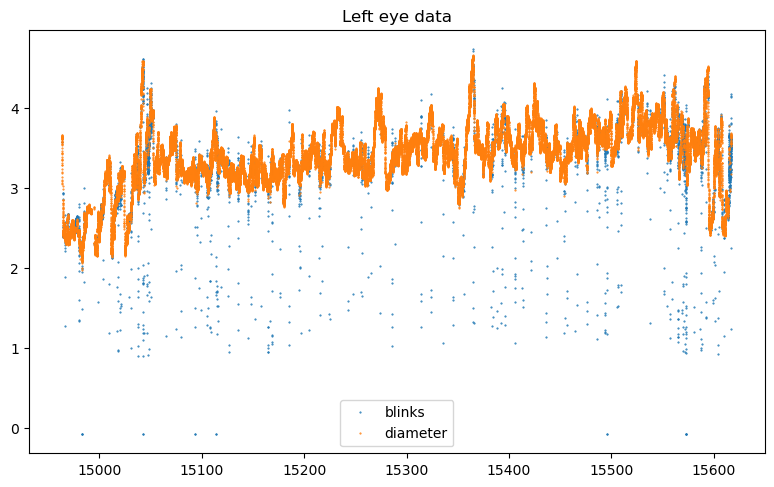

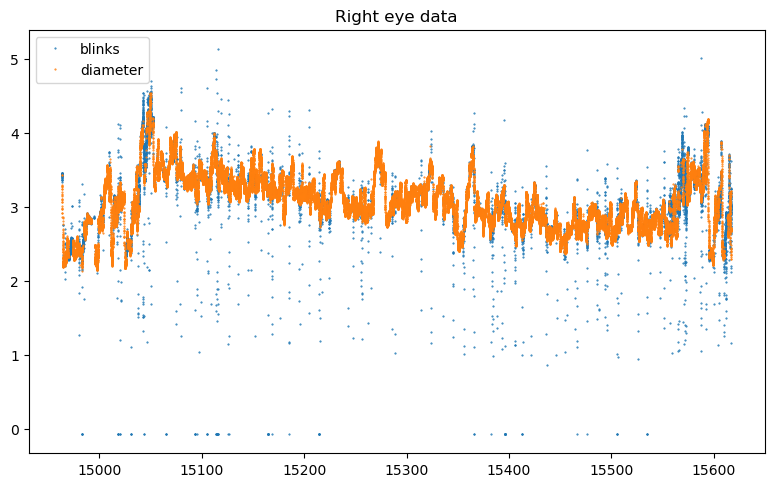

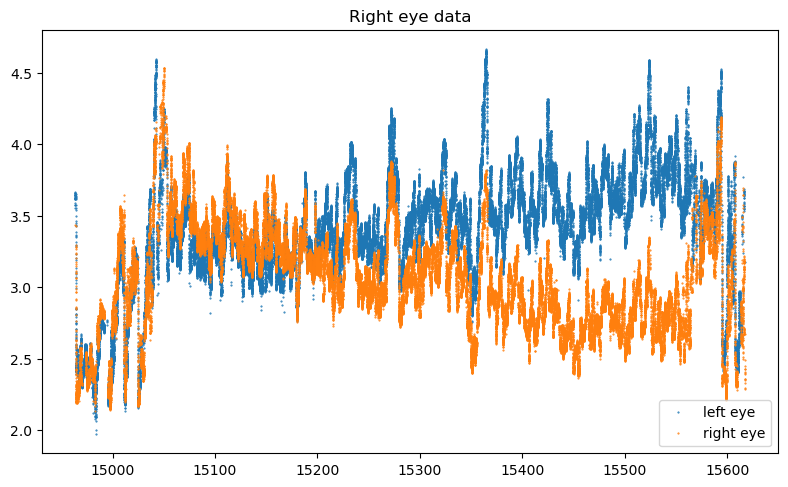

In [51]:
%matplotlib inline
#for left eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_left_eye['pupil_timestamp'],blinks_left_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Left eye data')

#for right eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_right_eye['pupil_timestamp'],blinks_right_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Right eye data')

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['left eye','right eye'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Right eye data')



### Do cubic splines aeasily, in the future use a better blink detection algorithm

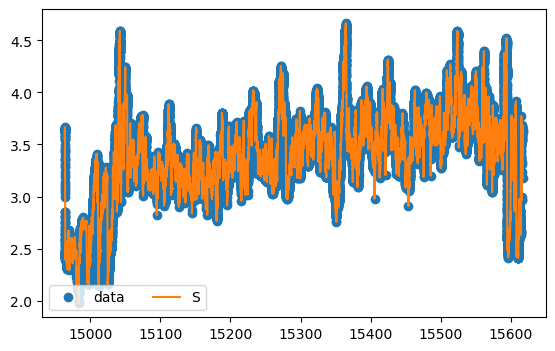

In [52]:
from scipy.interpolate import CubicSpline

def cubic_siplne_interpolation():
    print('hola')

x =pupil_left_eye['pupil_timestamp']
y = pupil_left_eye['diameter_3d']
time_1=blinks_left_eye['pupil_timestamp'].values[0]
time_end=blinks_left_eye['pupil_timestamp'].values[-1]
cs = CubicSpline(x, y)
xs = np.arange(time_1, time_end, 0.1)
pupil_diam_left_spline=cs(x)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(x, cs(x),'-', label="S")
ax.legend(loc='lower left', ncol=2)
plt.show()

In [123]:
s_cal=np.mean(y)-np.sqrt(np.mean(y)*2)
s_cal

0.7936800871304075

usaing smooting splines

In [124]:
# %matplotlib qt
# from scipy import interpolate
# tck = interpolate.splrep(x, y, s=s_cal)
# ynew = interpolate.splev(xs, tck, der=0)
# fig, ax = plt.subplots(figsize=(6.5, 4))
# ax.plot(x, y, 'o', label='data')
# ax.plot(xs, ynew,'-', label="S")
# ax.legend(loc='lower left', ncol=2)
# plt.show()

## Put timestamp data in seconds


In [127]:
# pupil_left_eye['pupil_timestamp']=pupil_left_eye['pupil_timestamp']-pupil_left_eye['pupil_timestamp'].values[0]
# pupil_left_eye['pupil_timestamp']

In [128]:
%matplotlib qt

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'])
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['confidence']*3)

ax.set_title('pupil diameter and confidence')    
plt.tight_layout()


## 

In [129]:
%matplotlib inline
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'],'.')
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter'],'.')
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row['timestamp'], color='r', label='axvline - full height')
    ax.text((row['timestamp']),30,row['label'])
ax.set_title('pupil diameter and events')    
plt.tight_layout()

## Apply normalizations
### Filters

In [53]:
filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


### Global Variables

In [95]:
pupil_df=pupil_right_eye
window=range(10,400)


### Asset normalization

In [96]:
#common variables
pupil_df=pupil_left_eye
pupil_df['diameter_3d']=pupil_diam_left_spline
# pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100).rolling(3).median())
y='diameter_3d'

secons_norm=0.4
frames_norm=np.round(secons_norm*pupil_sampling_freq_left).astype(int)
win_norm=range(frames_norm)
print('Initial frames used for normalization = {} correspond to {}s'.format(frames_norm,secons_norm))

window_s=3
window_frames=np.round(window_s*pupil_sampling_freq_left).astype(int)
print('Windows frames of interest   = {} correspond to {}s'.format(window_frames,window_s))
window=range(0,window_frames)
time_x=np.linspace(0,window_s,window_frames)



Initial frames used for normalization = 45 correspond to 0.4s
Windows frames of interest   = 340 correspond to 3s


C:\Users\Bolo\AppData\Local\Temp\ipykernel_25096\2090834319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_df['diameter_3d']=pupil_diam_left_spline


In [97]:
# For Assets
event=annotations_pd.loc[filter_assets,['label']]
pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_events_matrix[0:len(segmented_df),num]=(segmented_df[y]-win_blank['diameter_3d'].mean())


In [98]:
# For Surpriwe

event=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_surprise_matrix[0:len(segmented_df),num]=(segmented_df[y]-win_blank['diameter_3d'].mean())

### Do the plots

Text(0, 0.5, 'speed (s)')

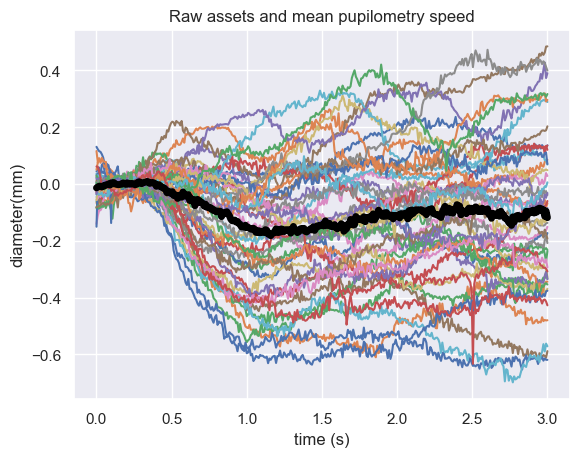

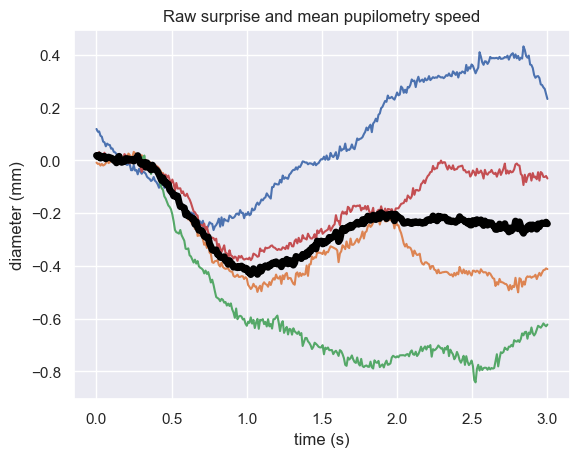

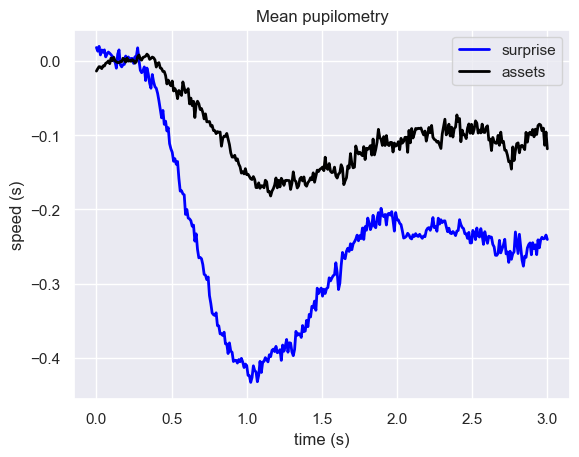

In [99]:
%matplotlib inline



mat=pupil_events_matrix
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat[window])
ax.plot(time_x,np.median(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')


mat=pupil_surprise_matrix
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat[window,:])
ax.plot(time_x,np.median(mat[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(time_x,np.median(pupil_surprise_matrix[window,:],axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.median(pupil_events_matrix[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

## Now lets calculate the speed of change from the normalized data

In [100]:

pupil_events_speed=np.abs(np.diff(pupil_events_matrix))
pupil_surprise_speed=np.abs(np.diff(pupil_surprise_matrix))

Text(0, 0.5, 'speed (s)')

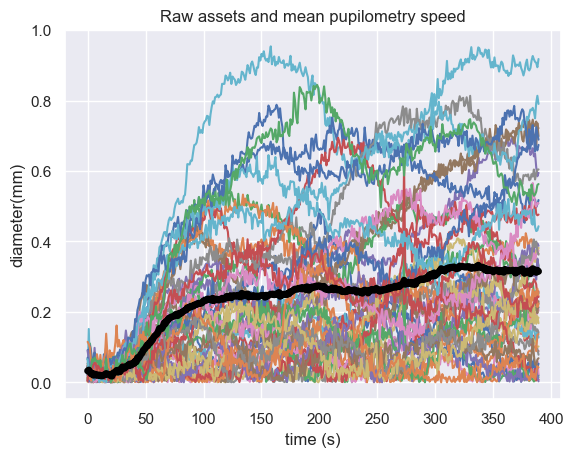

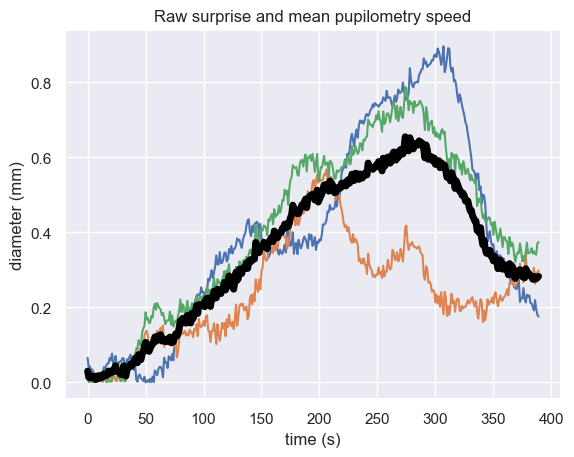

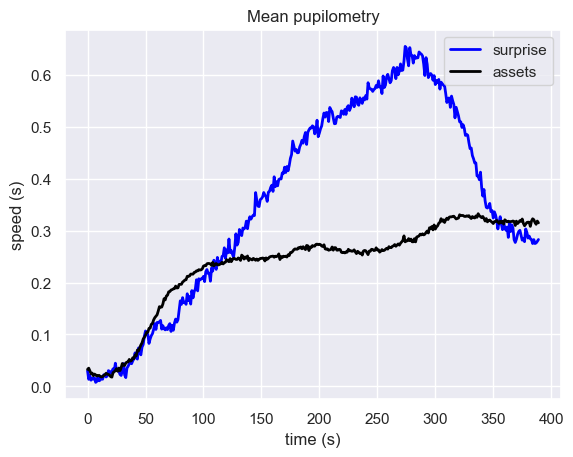

In [101]:
%matplotlib inline
window=range(10,400)

mat1=pupil_events_speed
mat2=pupil_surprise_speed

fig, ax=plt.subplots(1,1)
ax.plot(mat1[window])
ax.plot(np.mean(mat1[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')

fig, ax=plt.subplots(1,1)
ax.plot(mat2[window,:])
ax.plot(np.mean(mat2[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(np.mean(mat2[window,:],axis=1),linewidth=2,color='blue')
ax.plot(np.mean(mat1[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

Exclude data that is over [2,-2] z scores


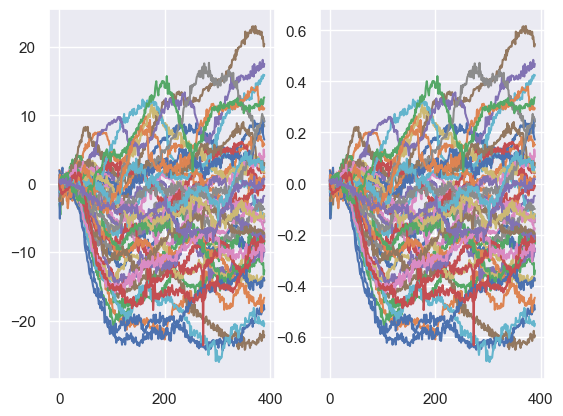

In [102]:
pupil_zscore=nm.normalize(values=pupil_events_matrix.reshape(pupil_events_matrix.size),
                                            type='z_score').reshape(pupil_events_matrix.shape)

fig, ax=plt.subplots(1,2)
ax[0].plot(pupil_zscore[window,:])
ax[1].plot(pupil_events_matrix[window,:])


<AxesSubplot: ylabel='Count'>

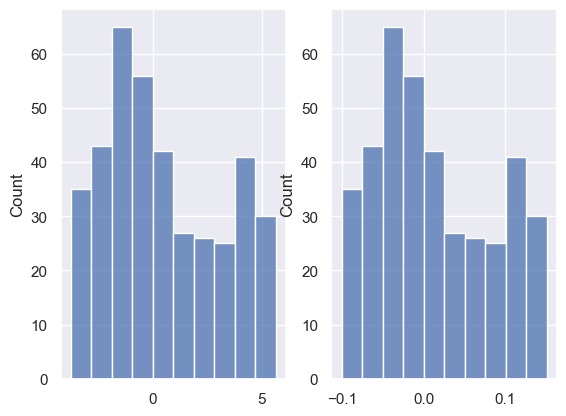

In [62]:
fig,ax=plt.subplots(1,2)
sns.histplot(pupil_zscore[window,6],ax=ax[0])
sns.histplot(pupil_events_matrix[window,6],ax=ax[1])

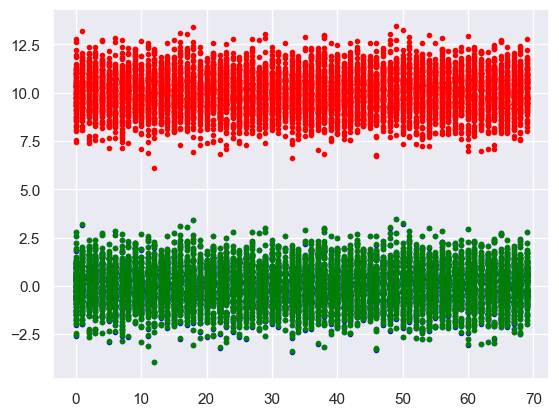

In [63]:
#test sfuntion
sigma=1
mu=10
data_normal=sigma*np.random.randn(70,100) +mu
data_norm=nm.normalize(values=data_normal.reshape(data_normal.size),
                                            type='z_score').reshape(data_normal.shape)
plt.plot(data_normal,'.',color='red')
plt.plot(data_norm,'.',color='blue')
plt.plot(data_normal-10,'.',color='green')


(array([[ 0.,  0.,  1., 12., 16., 19., 14.,  7.,  1.,  0.],
        [ 0.,  0.,  3., 10., 16., 16., 13., 10.,  1.,  1.],
        [ 0.,  2.,  2., 11., 16., 16., 16.,  3.,  3.,  1.],
        [ 0.,  0.,  3.,  8., 18., 18., 18.,  4.,  1.,  0.],
        [ 0.,  0.,  3., 14., 15., 21., 12.,  4.,  1.,  0.],
        [ 0.,  1.,  6.,  4., 15., 13., 17., 13.,  1.,  0.],
        [ 0.,  0.,  1.,  8., 20., 17., 17.,  4.,  1.,  2.],
        [ 0.,  2.,  2.,  4., 17., 26., 14.,  5.,  0.,  0.],
        [ 0.,  0.,  1.,  3., 14., 23., 21.,  6.,  2.,  0.],
        [ 0.,  1.,  1., 12., 15., 15., 18.,  8.,  0.,  0.],
        [ 0.,  0.,  7.,  8., 20., 22.,  9.,  4.,  0.,  0.],
        [ 0.,  0.,  1., 11., 22., 14., 14.,  7.,  0.,  1.],
        [ 0.,  0.,  1.,  6., 21., 18., 18.,  4.,  2.,  0.],
        [ 0.,  0.,  4.,  6., 11., 22., 14., 10.,  3.,  0.],
        [ 0.,  0.,  3.,  6., 20., 19., 14.,  3.,  5.,  0.],
        [ 0.,  1.,  4.,  6., 12., 29., 10.,  7.,  1.,  0.],
        [ 0.,  0.,  4.,  7., 19., 15., 1

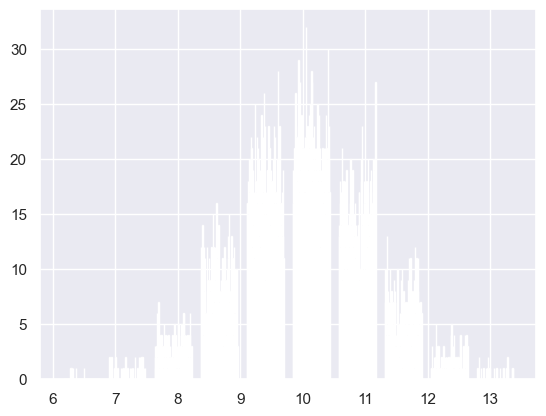

In [64]:
plt.hist(data_normal)


In [65]:
pupil_events_matrix.shape[0]

74182

In [66]:
r=a.reshape(pupil_events_matrix.shape)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
pupil_events_matrix.shape[0]*pupil_events_matrix.shape[1]

3029625

In [ ]:
pupil_events_matrix.shape

(67325, 45)